In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
import os.path
from pyedflib import highlevel
from scipy.signal import butter, lfilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


In [16]:
signal_len = 750
make_filter = False

def normalize(Y):
    X = Y.copy()
    X -= X.mean()
    # X /= np.abs(X).max()
    return X

def highpass(highcut, order, fs):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def final_filter(data, fs, order=2):
    if make_filter:
        b, a = highpass(56, order, fs)
        x = lfilter(b, a, data)
        return x
    return data

In [17]:
path = "../Data"

amy_path = os.path.join(path, "Amy/Amy")
amyc_path = os.path.join(path, "AmyC/AmyC")
norm_path = os.path.join(path, "AMY_add/AMY/2")

amy = []
amyc = []
norm = []

#signals, signal_headers, header = highlevel.read_edf(os.path.join(amy_path, "Amy1.edf"), ch_names=['ECG I'])
# print(signal_headers)
# print(header)

for name in os.listdir(amy_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(amy_path, name), ch_names=['ECG I'])

    signal = signals[0]
    amy.append(final_filter(signal, signal_headers[0]["sample_frequency"]))  

for name in os.listdir(amyc_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(amyc_path, name), ch_names=['ECG I'])

    signal = signals[0]
    amyc.append(final_filter(signal, signal_headers[0]["sample_frequency"]))  

for name in os.listdir(norm_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(norm_path, name), ch_names=['ECG I'])

    signal = signals[0]
    norm.append(final_filter(signal, signal_headers[0]["sample_frequency"]))  

sample_rate = signal_headers[0]["sample_frequency"]

In [18]:
norm_parts = []
amy_parts = []
amyc_parts = []

for record in norm:
    for i in range(int(record.shape[0] / signal_len) - 1):
        norm_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))

for record in amy:
    for i in range(int(record.shape[0] / signal_len) - 1):
        amy_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))
        
for record in amyc:
    for i in range(int(record.shape[0] / signal_len) - 1):
        amyc_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))

In [19]:
print(len(norm_parts), "- Norm parts")
print(len(amy_parts), "- amy parts")
print(len(amyc_parts), "- amyc parts")

norm_parts = np.array(norm_parts)
amy_parts = np.array(amy_parts)
amyc_parts = np.array(amyc_parts)

510 - Norm parts
396 - amy parts
310 - amyc parts


In [20]:
def extract_statistical_features(ecg_signal):
    features = {}
    features['mean'] = pd.Series(np.mean(ecg_signal, axis=1))
    features['std'] = pd.Series(np.std(ecg_signal, axis=1))
    features['min'] = pd.Series(np.min(ecg_signal, axis=1))
    features['max'] = pd.Series(np.max(ecg_signal, axis=1))
    features['range'] = pd.Series(np.ptp(ecg_signal, axis=1))  # max - min
    return features

def extract_frequency_features(ecg_signal):
    # Преобразование Фурье
    fft = np.fft.fft(ecg_signal)
    fft_mag = np.abs(fft)
    
    # Извлекаем частотные признаки
    features = {}
    features['freq_mean'] = pd.Series(np.mean(fft_mag, axis=1))
    features['freq_std'] = pd.Series(np.std(fft_mag, axis=1))
    features['freq_max'] = pd.Series(np.max(fft_mag, axis=1))
    features['freq_min'] = pd.Series(np.min(fft_mag, axis=1))
    
    return features

def extract_wavelet_features(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'db4', level=5)
    features = {}
    
    # Извлечение статистики для каждого уровня
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_mean_level_{i}'] = pd.Series(np.mean(coeff, axis=1))
        features[f'wavelet_std_level_{i}'] = pd.Series(np.std(coeff, axis=1))
    
    return features


In [21]:
data = np.concatenate([norm_parts, amy_parts])
lab = np.concatenate([np.zeros(len(norm_parts)), np.ones(len(amy_parts))])

stat = extract_statistical_features(data)
freq = extract_frequency_features(data)
wav = extract_wavelet_features(data)


data_df = pd.DataFrame({**stat, **freq, **wav})
data_df.head()

,mean,std,min,max,range,freq_mean,freq_std,freq_max,freq_min,wavelet_mean_level_0,...,wavelet_mean_level_1,wavelet_std_level_1,wavelet_mean_level_2,wavelet_std_level_2,wavelet_mean_level_3,wavelet_std_level_3,wavelet_mean_level_4,wavelet_std_level_4,wavelet_mean_level_5,wavelet_std_level_5
0,4.736952e-18,0.047374,-0.108563,0.406135,0.514698,0.489048,1.201678,10.432302,3.441691e-15,-0.008862,...,-0.017826,0.097484,0.004874,0.049517,-0.001934,0.025250,-4.903814e-04,0.005903,0.000005,0.001787
1,5.329071e-18,0.063542,-0.117285,0.431516,0.548801,0.626823,1.623346,14.093776,6.522560e-16,0.023351,...,0.028919,0.130336,-0.013622,0.101893,-0.001152,0.023438,-8.466259e-07,0.008768,-0.000003,0.002090
2,3.552714e-18,0.045611,-0.115056,0.409127,0.524184,0.489281,1.149300,9.843694,2.053913e-15,-0.014945,...,-0.003105,0.107604,-0.005375,0.072615,0.000897,0.033304,4.469777e-04,0.008758,-0.000005,0.001678
3,-2.368476e-18,0.058976,-0.117078,0.397168,0.514246,0.607664,1.496440,12.185622,1.242062e-15,-0.002276,...,0.009112,0.186849,-0.002898,0.126506,-0.002332,0.038814,7.683506e-05,0.010141,-0.000001,0.002059
4,-1.776357e-18,0.049641,-0.102778,0.406952,0.509730,0.500194,1.264098,12.263158,8.604228e-16,-0.010996,...,-0.001521,0.064613,-0.002811,0.069740,-0.000307,0.034854,1.412577e-04,0.007551,0.000007,0.001628


In [22]:
X = data_df # Признаки
y = lab  # Метки классов

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)}")

Random Forest accuracy: 0.8241758241758241
SVM accuracy: 0.5769230769230769


Epoch 1/10, Loss: 0.6794006565342778
Epoch 2/10, Loss: 0.6715320452399876
Epoch 3/10, Loss: 0.6755068431729856
Epoch 4/10, Loss: 0.6716965540595676
Epoch 5/10, Loss: 0.6653277355691661
Epoch 6/10, Loss: 0.6671347566272902
Epoch 7/10, Loss: 0.6603698704553687
Epoch 8/10, Loss: 0.6603293989015662
Epoch 9/10, Loss: 0.6564043267913486
Epoch 10/10, Loss: 0.6691049285556959
Accuracy: 52.747252747252745%
Voting accuracy: 0.5274725274725275

 clasification report:
               precision    recall  f1-score   support

           0       0.69      0.33      0.45       105
           1       0.47      0.79      0.59        77

    accuracy                           0.53       182
   macro avg       0.58      0.56      0.52       182
weighted avg       0.59      0.53      0.51       182

Матрица несоответствий для тестовой выборки метода ЛДА:



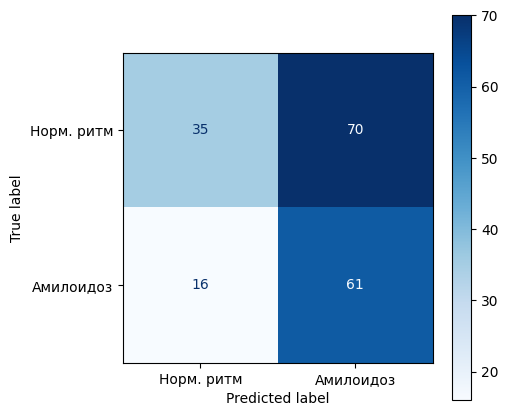

In [23]:
# Преобразуем данные в тензоры
X_tensor = torch.tensor(data_df.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Добавляем канал (для Conv1D)
y_tensor = torch.tensor(y, dtype=torch.long)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset, test_dataset = TensorDataset(X_train, y_train), TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определяем модель CNN
class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 3, 100)  # Рассчитайте размер выходного тензора после всех сверточных слоев
        self.fc2 = nn.Linear(100, 2)  # Выходной слой для двух классов

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 3)  # Выпрямляем тензор для fully connected слоев
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        y = [1 if i[1] > i[0] else 0 for i in x]
        return np.array(y)

# Создаем объект модели, определяем loss и optimizer
model = ECG_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Нулим градиенты
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

# Обучаем модель
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Тестируем модель
test_model(model, test_loader)

# Оценка точности
y_pred = model.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);



Voting accuracy: 0.8131868131868132

 clasification report:
               precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       105
         1.0       0.85      0.68      0.75        77

    accuracy                           0.81       182
   macro avg       0.82      0.79      0.80       182
weighted avg       0.82      0.81      0.81       182

Матрица несоответствий для тестовой выборки метода ЛДА:



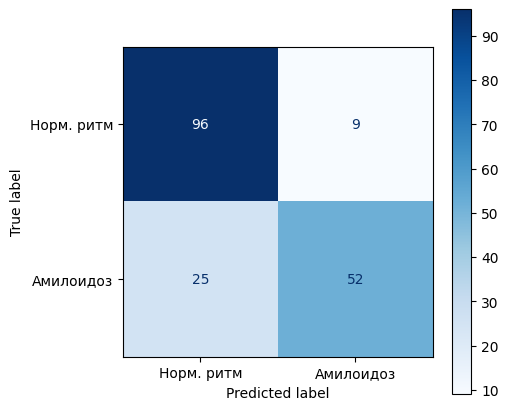

In [24]:
X = data_df # Признаки
y = lab  # Метки классов

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание нескольких классификаторов
rf = RandomForestClassifier()
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft')

# Обучение ансамбля
voting_clf.fit(X_train, y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred_voting))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);


In [25]:
def calcGroupTable(model, groupnames : list, records : list, df : pd.DataFrame):
    for i in range(len(groupnames)):
        record = records[i]
        parts = []
        for m in range(int(record.shape[0] / signal_len) - 1):
            parts.append(np.array(normalize(record[m*signal_len:(m+1) * signal_len])))

        y_pred = model.predict(pd.DataFrame({**extract_statistical_features(parts), **extract_frequency_features(parts), **extract_wavelet_features(parts)}))
        y_weighted = np.asarray(y_pred).sum() / len(y_pred)

        y_weighted = round(y_weighted)

        df.loc[-1] = [groupnames[i], y_weighted]
        df.index = df.index + 1
        df = df.sort_index()
    return df

In [26]:
# There are two classes. 0 - norm, 1 - amy

pred_tab = pd.DataFrame(columns=["name", "weighted_predict"])

norm_names = os.listdir(norm_path)
amy_names = os.listdir(amy_path)

norm_names = [name[:6] + "_norm" + name[6:] for name in norm_names]

pred_tab = calcGroupTable(voting_clf, norm_names, norm, pred_tab)
pred_tab = calcGroupTable(voting_clf, amy_names, amy, pred_tab)


pred_tab.head(5)

pred_tab.to_csv("voted_result.csv")